In [111]:
import numpy as np
import pandas as pd
import re
import operator
import pickle
from itertools import combinations
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import nltk
from nltk.corpus import wordnet as wn
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import decomposition
from sklearn.metrics import confusion_matrix, classification_report
np.random.seed(2021)

In [2]:
corpus = []

for path in Path(r'C:\Users\xiao\Documents\GitHub\DST-Assessment-3\Data\All enron unzip').rglob('*.txt'):
        with open(path, errors='ignore') as f_input:
            corpus.append(f_input.read())

In [3]:
df = pd.DataFrame(corpus)
df.columns = ['text']

In [4]:
len(df)

27721

In [5]:
df = df.drop([0,5173,11031,16544,21720]) # removing unnecessary entries
nlist = np.arange(0,27717,1) # reindexing
df = df.reindex(nlist)
df = df.drop(0)
df.columns = ['E-mails']

In [6]:
df

,E-mails
1,Subject: christmas tree farm pictures\n
2,"Subject: vastar resources , inc .\ngary , prod..."
3,Subject: calpine daily gas nomination\n- calpi...
4,Subject: re : issue\nfyi - see note below - al...
5,Subject: meter 7268 nov allocation\nfyi .\n- -...
...,...
27712,Subject: make big bucks in the medical field b...
27713,"Subject: proposal\ndear sir ,\nfirst i must so..."
27714,"Subject: cure premature ejaculation\nhello ,\n..."
27715,Subject: need your vics ?\nbrand name meds suc...


In [7]:
z1 = np.arange(3673,5173)
z2 = np.arange(9534,11031)
z3 = np.arange(15043,16544)
z4 = np.arange(18043,21719)
z5 = np.arange(23220,27716)
ze = np.concatenate((z1,z2,z3,z4,z5))

In [8]:
z = np.zeros(27716)
df['spam'] = z
for i in ze:
    df.iloc[i,1] = 1

In [9]:
df

,E-mails,spam
1,Subject: christmas tree farm pictures\n,0.0
2,"Subject: vastar resources , inc .\ngary , prod...",0.0
3,Subject: calpine daily gas nomination\n- calpi...,0.0
4,Subject: re : issue\nfyi - see note below - al...,0.0
5,Subject: meter 7268 nov allocation\nfyi .\n- -...,0.0
...,...,...
27712,Subject: make big bucks in the medical field b...,1.0
27713,"Subject: proposal\ndear sir ,\nfirst i must so...",1.0
27714,"Subject: cure premature ejaculation\nhello ,\n...",1.0
27715,Subject: need your vics ?\nbrand name meds suc...,1.0


In [10]:
df['index'] = df.index

In [11]:
df

,E-mails,spam,index
1,Subject: christmas tree farm pictures\n,0.0,1
2,"Subject: vastar resources , inc .\ngary , prod...",0.0,2
3,Subject: calpine daily gas nomination\n- calpi...,0.0,3
4,Subject: re : issue\nfyi - see note below - al...,0.0,4
5,Subject: meter 7268 nov allocation\nfyi .\n- -...,0.0,5
...,...,...,...
27712,Subject: make big bucks in the medical field b...,1.0,27712
27713,"Subject: proposal\ndear sir ,\nfirst i must so...",1.0,27713
27714,"Subject: cure premature ejaculation\nhello ,\n...",1.0,27714
27715,Subject: need your vics ?\nbrand name meds suc...,1.0,27715


In [12]:
df[df['index'] == 1].values[0][0]

'Subject: christmas tree farm pictures\n'

## Data Cleaning

In [13]:
en_stop = nltk.corpus.stopwords.words('english')
en_stop.append('Subject')
#en_stop.append('enron')

In [14]:
def get_lemma(word):
    ## morphy does a lemma lookup and word standardization
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [15]:
def prepare_text(text):
    ## Runs on documents (vector of words)
    
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if len(token) > 3]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [16]:
df['E-mails'] = [re.sub(r'[^\w\s]','',str(x)) for x in df['E-mails']]

In [17]:
df.head(5)

,E-mails,spam,index
1,Subject christmas tree farm pictures\n,0.0,1
2,Subject vastar resources inc \ngary producti...,0.0,2
3,Subject calpine daily gas nomination\n calpine...,0.0,3
4,Subject re issue\nfyi see note below alread...,0.0,4
5,Subject meter 7268 nov allocation\nfyi \n ...,0.0,5


In [18]:
#email_sample = df.iloc[1].values[0] # some of the emails are less tasteful than other emails sorry!
#print(email_sample)

In [19]:
#nltk.download('punkt')
#nltk.download('wordnet')

In [20]:
text = df['E-mails']

In [21]:
text_new = df['E-mails'].map(prepare_text)

In [22]:
text_new

1                         [christmas, tree, farm, picture]
2        [vastar, resource, gary, production, high, isl...
3        [calpine, daily, nomination, calpine, daily, n...
4        [issue, note, already, do, stella, forward, st...
5        [meter, 7268, allocation, forward, lauri, alle...
                               ...                        
27712    [make, buck, medical, field, bait, excel, prob...
27713    [proposal, dear, first, must, solicit, strict,...
27714    [cure, premature, ejaculation, hello, ejaculat...
27715    [need, vics, brand, name, med, vics, vals, xan...
27716    [8859, good, news, edaliss, edumm, eoggra, hel...
Name: E-mails, Length: 27716, dtype: object

In [23]:
text

1                   Subject christmas tree farm pictures\n
2        Subject vastar resources  inc \ngary  producti...
3        Subject calpine daily gas nomination\n calpine...
4        Subject re  issue\nfyi  see note below  alread...
5        Subject meter 7268 nov allocation\nfyi \n     ...
                               ...                        
27712    Subject make big bucks in the medical field ba...
27713    Subject proposal\ndear sir \nfirst i must soli...
27714    Subject cure premature ejaculation\nhello \ndi...
27715    Subject need your vics \nbrand name meds such ...
27716    Subject   iso  8859  1  q  good _ news _ c  ed...
Name: E-mails, Length: 27716, dtype: object

In [24]:
text2 = [[' '.join(i)] for i in text_new]

In [25]:
df2 = pd.DataFrame(text2)
df2.columns = ['E-mails']
df2

,E-mails
0,christmas tree farm picture
1,vastar resource gary production high island la...
2,calpine daily nomination calpine daily nomination
3,issue note already do stella forward stella mo...
4,meter 7268 allocation forward lauri allen kimb...
...,...
27711,make buck medical field bait excel problem see...
27712,proposal dear first must solicit strict confid...
27713,cure premature ejaculation hello ejaculate wit...
27714,need vics brand name med vics vals xanies othe...


In [26]:
text_processed = df2['E-mails']

In [27]:
# use a custom stopwords list, set the minimum term-document frequency to 10
vectorizer = CountVectorizer(stop_words = 'english', min_df = 10)
A = vectorizer.fit_transform(text_processed)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Created 27716 X 14754 document-term matrix


In [28]:
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 14754 distinct terms


In [29]:
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [30]:
ranking = rank_terms( A, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

01. enron (60298.00)
02. company (26077.00)
03. 2001 (14955.00)
04. 2000 (14101.00)
05. subject (13289.00)
06. say (12906.00)
07. business (12745.00)
08. price (12234.00)
09. information (11405.00)
10. need (11240.00)
11. make (11148.00)
12. market (10794.00)
13. energy (10769.00)
14. time (10677.00)
15. know (9894.00)
16. forward (9529.00)
17. email (9256.00)
18. report (9216.00)
19. deal (9054.00)
20. message (8820.00)


## Model

In [76]:
k=10

In [77]:
# create the model

model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform(A)
H = model.components_

D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [33]:
W.shape

(27716, 10)

In [34]:
type(W)

numpy.ndarray

In [35]:
W[0,:].round(3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
H.shape

(10, 14754)

In [37]:
term_index = terms.index('enron')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([5.982e+01, 0.000e+00, 4.560e+00, 0.000e+00, 2.000e-02, 0.000e+00,
       1.210e+00, 1.710e+00, 0.000e+00, 1.500e-01])

In [38]:
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

In [39]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: enron, corp, 2000, company, communications, john, trading, business, assets, officer
Topic 02: company, statement, security, information, report, stock, forward, investment, looking, future
Topic 03: dynegy, say, company, deal, share, stock, energy, billion, merger, trading
Topic 04: mail, report, email, order, make, address, money, people, program, receive
Topic 05: company, energy, market, business, power, financial, price, times, billion, year
Topic 06: power, state, mseb, project, say, board, notice, government, 2001, termination
Topic 07: say, company, bankruptcy, million, billion, energy, dynegy, 2001, york, share
Topic 08: credit, say, company, rating, billion, jones, 2001, trading, energy, debt
Topic 09: subject, 2000, vince, 2001, kaminski, forward, message, thanks, need, know
Topic 10: company, say, fastow, share, partnership, stock, investor, financial, analyst, million


In [40]:
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [41]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="blue",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

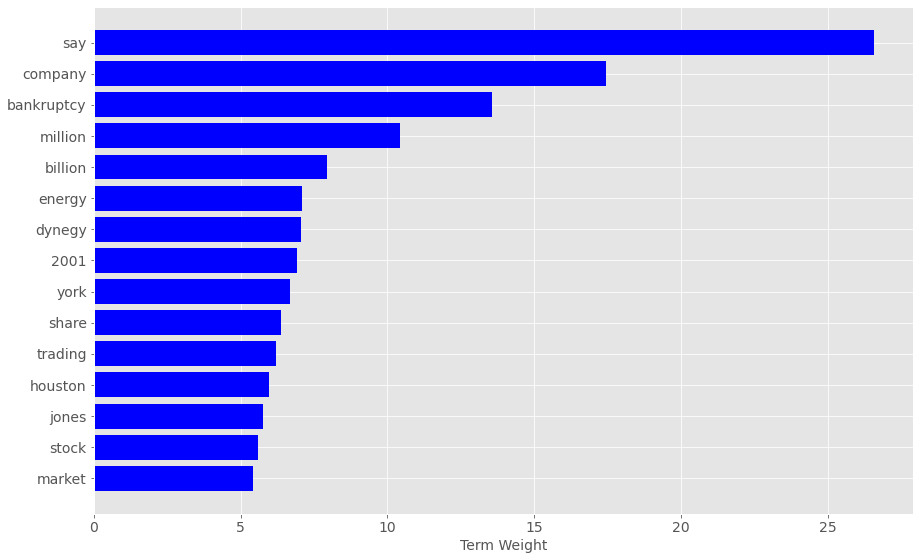

In [42]:
plot_top_term_weights( terms, H, 6, 15 )

In [78]:
train_x = W
train_y = list(df['spam'])
test_x = W
test_y = list(df['spam'])

In [79]:
clf_tree = DecisionTreeClassifier(random_state=10)
clf_tree.fit(train_x, train_y)
pre_tree = clf_tree.predict(test_x)
acc_tree=accuracy_score(pre_tree, test_y)
print("------------------------------------------")
print("Accuracy = ",acc_tree*100," %")

------------------------------------------
Accuracy =  99.97113580603262  %


## Parameter Selection

In [101]:
kmin, kmax = 2, 30

topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=2 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=3 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=4 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=5 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=6 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=7 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=8 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=9 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=10 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=11 ...
Applying NMF for k=12 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=13 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=14 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=15 ...
Applying NMF for k=16 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=17 ...
Applying NMF for k=18 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=19 ...
Applying NMF for k=20 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=21 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=22 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=23 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=24 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=25 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=26 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=27 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=28 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=29 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Applying NMF for k=30 ...


D:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [46]:
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [59]:
docgen = TokenGenerator(text_processed, en_stop)
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=100, min_count=10, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [60]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 17698 terms


In [61]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        b = 0
        for pair in combinations( term_rankings[topic_index], 2 ):
            a = w2v_model.similarity(pair[0], pair[1])
            pair_scores.append(a)
            b += a
        # get the mean for all pairs in this topic
        #b = sum(pair_scores)
        c = len(pair_scores)
        topic_score = b/c 
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [102]:
k_values = []
coherences = []

for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    a = calculate_coherence( w2v_model, term_rankings )
    coherences.append( a )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=02: Coherence=0.3211
K=03: Coherence=0.3384
K=04: Coherence=0.3216
K=05: Coherence=0.3309
K=06: Coherence=0.3357
K=07: Coherence=0.3289
K=08: Coherence=0.3325
K=09: Coherence=0.3445
K=10: Coherence=0.3428
K=11: Coherence=0.3544
K=12: Coherence=0.3528
K=13: Coherence=0.3536
K=14: Coherence=0.3522
K=15: Coherence=0.3562
K=16: Coherence=0.3480
K=17: Coherence=0.3495
K=18: Coherence=0.3522
K=19: Coherence=0.3491
K=20: Coherence=0.3488
K=21: Coherence=0.3518
K=22: Coherence=0.3512
K=23: Coherence=0.3535
K=24: Coherence=0.3507
K=25: Coherence=0.3537
K=26: Coherence=0.3549
K=27: Coherence=0.3538
K=28: Coherence=0.3498
K=29: Coherence=0.3506
K=30: Coherence=0.3543


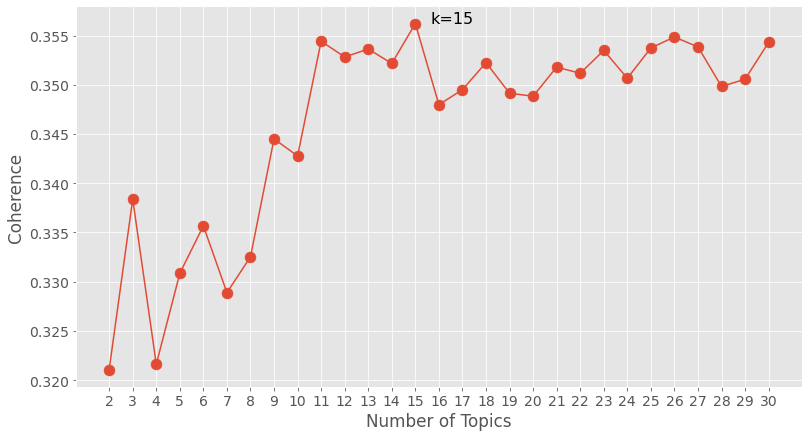

In [103]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [104]:
k=15

In [105]:
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform(A)
H = model.components_

In [106]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: enron, corp, 2000, communications, john, jones, market, assets, mark, business
Topic 02: company, statement, security, information, report, forward, investment, stock, looking, future
Topic 03: dynegy, say, company, deal, energy, trading, share, billion, merger, stock
Topic 04: subject, 2000, vince, 2001, kaminski, forward, message, thanks, know, need
Topic 05: company, say, energy, billion, financial, investor, power, business, times, houston
Topic 06: power, state, mseb, project, board, say, notice, government, termination, 2001
Topic 07: say, company, bankruptcy, billion, energy, million, houston, trading, york, dynegy
Topic 08: credit, rating, say, company, billion, trading, debt, week, moody, share
Topic 09: say, 2001, jones, million, company, percent, quarter, news, reuters, copyright
Topic 10: say, company, fastow, partnership, share, financial, stock, investor, chief, analyst
Topic 11: http, font, height, width, nbsp, size, style, align, family, border
Topic 12: marke

In [107]:
train_x1 = W
train_y = list(df['spam'])
test_x1 = W
test_y = list(df['spam'])

In [108]:
W.shape

(27716, 15)

In [109]:
clf_tree1 = DecisionTreeClassifier(random_state=10)
clf_tree1.fit(train_x1, train_y)
pre_tree1 = clf_tree1.predict(test_x1)
acc_tree1 = accuracy_score(pre_tree1, test_y)
print("------------------------------------------")
print("Accuracy = ",acc_tree1*100," %")

------------------------------------------
Accuracy =  99.97113580603262  %


In [99]:
def classification_eval(y_true,y_pred):
    
    print("Confusion Matrix")
    C = confusion_matrix(y_true,y_pred)
    
    print('Classification report')
    print(classification_report(y_true, y_pred, target_names = ['Normal', 'Spam'], digits=3))

In [100]:
classification_eval(test_y,pre_tree1)

Confusion Matrix
Classification report
              precision    recall  f1-score   support

      Normal      1.000     1.000     1.000     15046
        Spam      0.999     1.000     1.000     12670

    accuracy                          1.000     27716
   macro avg      1.000     1.000     1.000     27716
weighted avg      1.000     1.000     1.000     27716



In [113]:
pickle.dump(pre_tree1, open('Xiao_pred.p','wb'))

In [125]:
pickle.dump(test_y, open('Xiao_actual.p','wb'))

In [123]:
coherences[13]

0.3562144095312666

In [124]:
pickle.dump(coherences[13], open('Xiao_opt_value.p','wb'))